<a href="https://colab.research.google.com/github/prateekmanral011/hackathon_spg_slb/blob/main/Map_view_nearest_fault.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Feature rows: 50651
Plotting WellID, sample: A10 10 at 456980.074 6782712.237
Nearest fault id/type: Closing_Fault_South_2 (1) closing


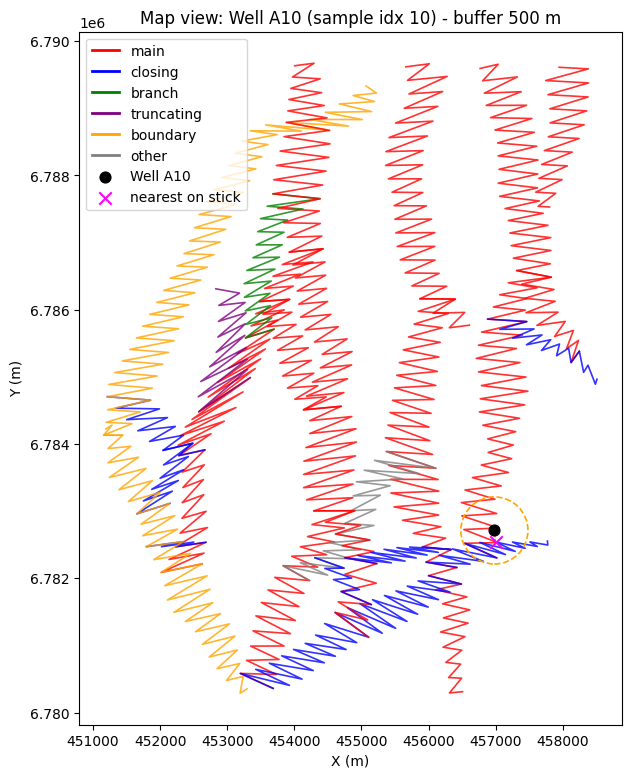

In [ ]:
# Map view plotting: well sample, nearest fault point, faults colored by type
import matplotlib.pyplot as plt
import pandas as pd
import glob, os
from shapely.geometry import Point, LineString
from shapely.ops import unary_union
import numpy as np

# --- Config: update if needed ---
FEATURE_CSV = "/content/well_structural_features_all_depths.csv"  # output CSV from script
STICK_FOLDER = "/content/sticks/"  # same folder used earlier
SAMPLE_INDEX = 10    # which row in the feature CSV to visualize (change to try others)
BUFFER_R = 500      # buffer radius in meters to show

# --- Load feature CSV ---
df = pd.read_csv(FEATURE_CSV)
print("Feature rows:", len(df))

# pick a sample row
if SAMPLE_INDEX >= len(df):
    SAMPLE_INDEX = 0
row = df.iloc[SAMPLE_INDEX]
px, py = row['X'], row['Y']
print("Plotting WellID, sample:", row['WellID'], SAMPLE_INDEX, "at", px, py)
print("Nearest fault id/type:", row.get('nearest_fault_id'), row.get('nearest_fault_type'))

# --- Load sticks if not present ---
def load_sticks_from_folder(folder):
    sticks_local = []
    files = glob.glob(os.path.join(folder, "*.csv"))
    for fp in files:
        try:
            tmp = pd.read_csv(fp, header=0)
            # guess numeric columns for XY
            numeric_cols = []
            for c in tmp.columns:
                if pd.to_numeric(tmp[c], errors='coerce').notna().sum() > 1:
                    numeric_cols.append(c)
                if len(numeric_cols) >= 3:
                    break
            if len(numeric_cols) < 2:
                continue
            xcol, ycol = numeric_cols[0], numeric_cols[1]
            xs = pd.to_numeric(tmp[xcol], errors='coerce').dropna().values
            ys = pd.to_numeric(tmp[ycol], errors='coerce').dropna().values
            if len(xs) < 2:
                continue
            ls = LineString(list(zip(xs, ys)))
            # infer type and fault_id from filename (simple heuristic)
            fname = os.path.basename(fp)
            fid = fname
            ftype = 'other'
            ln = fname.lower()
            if 'main' in ln: ftype='main'
            elif 'closing' in ln: ftype='closing'
            elif 'branch' in ln or 'branched' in ln: ftype='branch'
            elif 'truncat' in ln: ftype='truncating'
            elif 'boundary' in ln: ftype='boundary'
            sticks_local.append({'name': fname, 'linestring': ls, 'fault_type': ftype, 'fault_id': fid})
        except Exception as e:
            # skip problematic files
            print("skip", fp, e)
    return sticks_local

# try to use sticks list if it's in memory; otherwise load
try:
    sticks  # if defined earlier
    sticks_present = True
except NameError:
    sticks_present = False

if not sticks_present:
    print("Loading sticks from folder...")
    sticks = load_sticks_from_folder(STICK_FOLDER)

# prepare fault geometries grouped by fault_id (merge multiple sticks of same fault if present)
from collections import defaultdict
fault_geoms = {}
fault_type_map = {}
group = defaultdict(list)
for s in sticks:
    group[s['fault_id']].append(s['linestring'])
    fault_type_map[s['fault_id']] = s['fault_type']
for fid, lines in group.items():
    try:
        merged = LineString()
        if len(lines) == 1:
            merged = lines[0]
        else:
            # attempt merge; fallback to MultiLine approach
            merged = unary_union(lines)  # can be MultiLineString or LineString
    except Exception:
        merged = unary_union(lines)
    fault_geoms[fid] = merged

# --- Plotting ---
fig, ax = plt.subplots(figsize=(9,9))

# color map for types
color_map = {'main':'red','closing':'blue','branch':'green','truncating':'purple','boundary':'orange','other':'gray'}
# plot all faults
for fid, geom in fault_geoms.items():
    ftype = fault_type_map.get(fid, 'other')
    col = color_map.get(ftype, 'gray')
    if geom is None:
        continue
    # handle MultiLineString
    if hasattr(geom, 'geoms'):
        for seg in geom.geoms:
            xs, ys = seg.xy
            ax.plot(xs, ys, color=col, linewidth=1.2, alpha=0.8)
    else:
        try:
            xs, ys = geom.xy
            ax.plot(xs, ys, color=col, linewidth=1.2, alpha=0.8)
        except Exception:
            # sometimes geometry types differ; skip if cannot plot
            continue

# plot well point
ax.scatter(px, py, c='black', s=60, zorder=5, label=f"Well {row['WellID']}")
# plot circle buffer
circ = plt.Circle((px,py), BUFFER_R, color='orange', fill=False, linestyle='--', linewidth=1.2, zorder=4)
ax.add_patch(circ)

# plot nearest point if available in df (nx,ny) else compute nearest vertex and plot that
if {'nearest_stick_name','nearest_fault_id'}.issubset(df.columns) and not pd.isna(row['nearest_stick_name']):
    # try compute nearest point on that stick: find stick by name
    name = row['nearest_stick_name']
    found = None
    for s in sticks:
        if s['name'] == name or s['name'].startswith(name):
            found = s['linestring']
            break
    if found is not None:
        # compute nearest point on the geometry
        nearest_pt = found.interpolate(found.project(Point(px,py)))
        nx, ny = nearest_pt.x, nearest_pt.y
        ax.scatter([nx], [ny], c='magenta', s=80, marker='x', label='nearest on stick', zorder=6)
        ax.plot([px, nx], [py, ny], color='magenta', linewidth=0.8, linestyle=':', zorder=3)
else:
    # approximate by nearest vertex
    # build vertex list
    all_verts = []
    for s in sticks:
        xs, ys = np.array(s['linestring'].xy)
        for xi, yi in zip(xs, ys):
            all_verts.append((xi, yi))
    if len(all_verts) > 0:
        verts = np.array(all_verts)
        from scipy.spatial import cKDTree
        tree = cKDTree(verts)
        d, idx = tree.query([px,py], k=1)
        nx, ny = verts[int(idx)]
        ax.scatter([nx], [ny], c='magenta', s=80, marker='x', label='nearest vertex', zorder=6)
        ax.plot([px, nx], [py, ny], color='magenta', linewidth=0.8, linestyle=':', zorder=3)

# add legend for fault types
legend_elements = []
for t, c in color_map.items():
    legend_elements.append(plt.Line2D([0],[0], color=c, lw=2, label=t))
ax.legend(handles=legend_elements + ax.get_legend_handles_labels()[0], loc='best')

ax.set_title(f"Map view: Well {row['WellID']} (sample idx {SAMPLE_INDEX}) - buffer {BUFFER_R} m")
ax.set_xlabel("X (m)"); ax.set_ylabel("Y (m)")
ax.set_aspect('equal')
plt.show()


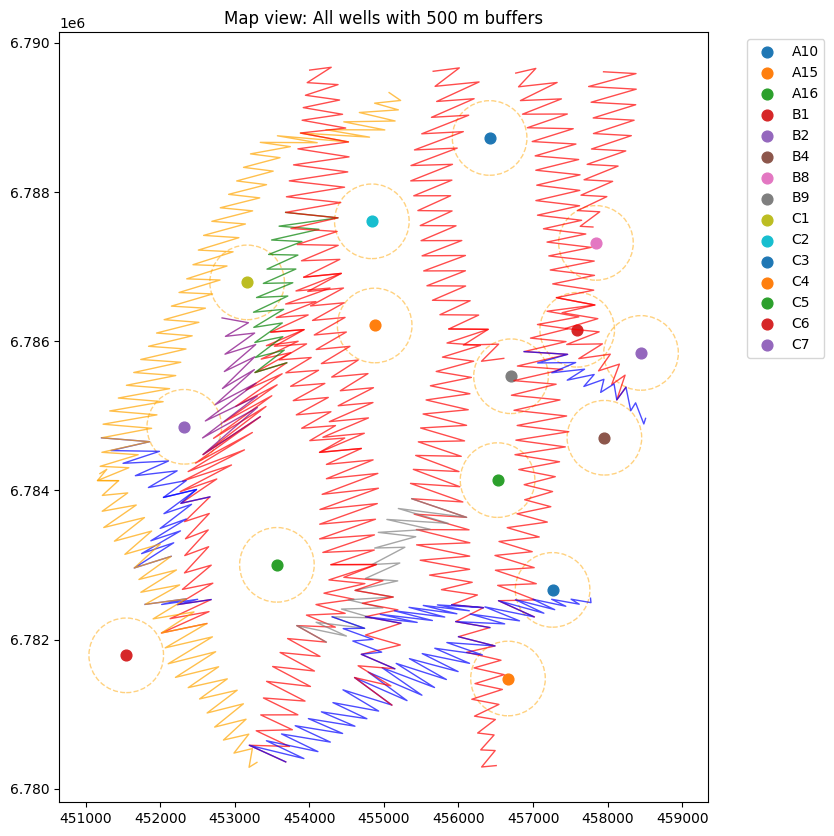

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))

# plot faults
color_map = {'main':'red','closing':'blue','branch':'green','truncating':'purple','boundary':'orange','other':'gray'}
for fid, geom in fault_geoms.items():
    ftype = fault_type_map.get(fid,'other')
    col = color_map.get(ftype,'gray')
    if geom is None: continue
    if hasattr(geom,'geoms'):
        for g in geom.geoms:
            xs, ys = g.xy
            ax.plot(xs, ys, color=col, lw=1, alpha=0.7)
    else:
        xs, ys = geom.xy
        ax.plot(xs, ys, color=col, lw=1, alpha=0.7)

# plot wells
for wid in df['WellID'].unique():
    sub = df[df['WellID']==wid]
    px, py = sub['X'].mean(), sub['Y'].mean()
    ax.scatter(px, py, s=60, label=wid)
    circ = plt.Circle((px,py), 500, color='orange', fill=False, linestyle='--', alpha=0.5)
    ax.add_patch(circ)

ax.set_title("Map view: All wells with 500 m buffers")
ax.set_aspect('equal')
ax.legend(bbox_to_anchor=(1.05,1), loc='upper left')
plt.show()
